## **Using a Convolutional Neural Network to Identify Simulated Nanoparticle Rotations | Regression Model**

In this notebook, a convolutional neural network will be constructed and trained on images of simulated nanoparticles. The aim of the neural network is to correctly identify the rotations of these nanoparticles. TensorFlow2 and Keras will be used to create a regression model.

All of my work can be found at https://github.com/javidahmed64592/Y4-Nanoparticles-Project.

# Importing the relevant libraries.

In [3]:
import datetime
import matplotlib.pyplot as plt
import numpy as np
import os
import json
import PIL
from scipy.spatial.transform import Rotation as R

import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras.models import Sequential
from tensorflow.keras.optimizers import SGD

# Creating the dataset.

The images will be loaded in from Google Drive.

In [4]:
from google.colab import drive
drive_path = "/content/drive"
drive.mount(drive_path)

cwd = os.path.join(drive_path, "MyDrive", "Nanoparticles")
folder_name = "Tetras Centred RX 0-45 RY 0-45 Augmented"
direc = os.path.join(cwd, folder_name)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


The following function loads in images from a specified folder path. The folder contains subfolders for each nanoparticle orientation. The images are loaded in using PIL as NumPy arrays and returns them along with the file name and their orientations.

In [5]:
def load_imgs_from_path(folder_path):
  print("\nLoading images from '%s'..." % folder_path.split("/")[-1])
  imgs = []
  img_names = []
  labels = []

  counter = 0
  
  for rotation in os.listdir(folder_path):
    rotation_path = os.path.join(folder_path, rotation)
    label = json.loads(rotation)
    for image_name in os.listdir(rotation_path):
      labels.append(np.asarray(label))
      img = PIL.Image.open(os.path.join(rotation_path, image_name)).convert('L')

      img_array = np.asarray(img)
      imgs.append(img_array)
      img_names.append(image_name)

      counter += 1
      print("\r%s images loaded." % (counter), end='', flush=True)

      img.close()

  imgs = np.asarray(imgs)
  imgs = imgs.reshape(*imgs.shape, 1)

  print("\rFound %s images from the '%s' dataset." % (counter, folder_path.split("/")[-1]), end='', flush=True)

  return imgs, np.asarray(img_names), np.asarray(labels)

80% of the images will be used for the training dataset, and 20% will be used for the validation dataset. A testing dataset the same size as the validation dataset will be used to test the model.

In [6]:
begin_time = datetime.datetime.now()

training_path = os.path.join(direc, "Train")
validation_path = os.path.join(direc, "Valid")
testing_path = os.path.join(direc, "Test")

train_imgs, train_names, train_labels = load_imgs_from_path(training_path)
valid_imgs, valid_names, valid_labels = load_imgs_from_path(validation_path)
test_imgs, test_names, test_labels = load_imgs_from_path(testing_path)

dt = datetime.datetime.now() - begin_time
dt_m = int(dt.total_seconds() // 60)
dt_s = int(dt.total_seconds() - (dt_m*60))
print("\n\nDone! The time it took is %sm %ss." % (dt_m, dt_s))


Loading images from 'Train'...
Found 11520 images from the 'Train' dataset.
Loading images from 'Valid'...
Found 2880 images from the 'Valid' dataset.
Loading images from 'Test'...
Found 960 images from the 'Test' dataset.

Done! The time it took is 1m 47s.


The following neural network layers are used to resize the images and map their pixel values to a float between 0 and 1. The training and validation images will have random augmentations applied to them.

In [7]:
img_size = [64, 64]

train_augmentation = keras.Sequential(
  [
    layers.Resizing(*img_size),
    layers.Rescaling(1./255),
    #layers.RandomFlip("horizontal", input_shape=(*img_size, 1)),
    #layers.RandomRotation(0.1),
    #layers.RandomZoom(0.1),
  ]
)

test_augmentation = keras.Sequential(
  [
    layers.Resizing(*img_size),
    layers.Rescaling(1./255),
  ]
)

The following function creates a dataset from the image arrays and their corresponding labels along with one of the above augmentations and a batch size. The dataset is shuffled and the images are prefetched to use with the model.

In [8]:
def create_dataset(imgs, labels, aug, batch_size, shuffle=False):
  dataset = tf.data.Dataset.from_tensor_slices((imgs, labels))
  
  if shuffle:
    dataset = dataset.shuffle(batch_size * 10)

  dataset = (
    dataset
    .batch(batch_size)
    .map(lambda x, y: (aug(x), y),
      num_parallel_calls=tf.data.AUTOTUNE)
    .prefetch(tf.data.AUTOTUNE)
  )
  return dataset

batch_size = 8

In [9]:
train_dataset = create_dataset(train_imgs, train_labels, train_augmentation, batch_size, shuffle=True)
valid_dataset = create_dataset(valid_imgs, valid_labels, train_augmentation, batch_size)
test_dataset = create_dataset(test_imgs, test_labels, test_augmentation, batch_size)

# Creating the model.

The following function shows the layers of the convolutional neural network.

In [10]:
# def get_model(n_outputs):
#   model = Sequential([
#     layers.Conv2D(16, 3, padding='same', activation='relu', kernel_regularizer=keras.regularizers.l2(0.01), input_shape=(*img_size, 1), name='Convolution_16_3x3'),
#     layers.MaxPooling2D(pool_size=2, strides=2, name='Max_Pooling_2x2_Stride_2_1'),
#     layers.Conv2D(32, 3, padding='same', activation='relu', kernel_regularizer=keras.regularizers.l2(0.01), name='Convolution_32_3x3'),
#     layers.MaxPooling2D(pool_size=2, strides=2, name='Max_Pooling_2x2_Stride_2_2'),
#     layers.Conv2D(64, 3, padding='same', activation='relu', kernel_regularizer=keras.regularizers.l2(0.01), name='Convolution_64_3x3'),
#     layers.MaxPooling2D(pool_size=2, strides=2, name='Max_Pooling_2x2_Stride_2_3'),
#     layers.Flatten(name='Flatten'),
#     # layers.Dense(img_size[0] * 4, activation='relu', name='Dense_%s' % img_size[0]*4),
#     # layers.Dropout(0.5, name='Dropout_50'),
#     layers.Dense(img_size[0] * 2, activation='relu', kernel_regularizer=keras.regularizers.l2(0.01), name='Dense_%s' % img_size[0]*2),
#     layers.Dropout(0.25, name='Dropout_25'),
#     layers.Dense(img_size[0], activation='relu', kernel_regularizer=keras.regularizers.l2(0.01), name='Dense_%s' % img_size[0]),
#     layers.Dense(n_outputs, name='Dense_%s' % n_outputs)
#   ])

#   return model

In [30]:
def get_model(n_outputs):
  model = Sequential([
    layers.Conv2D(16, 3, padding='same', activation='relu', input_shape=(*img_size, 1), name='Convolution_16_3x3_1'),
    layers.MaxPooling2D(pool_size=2, strides=2, name='Max_Pooling_2x2_Stride_2_1'),
    layers.Conv2D(32, 3, padding='same', activation='relu', name='Convolution_32_3x3_1'),
    layers.MaxPooling2D(pool_size=2, strides=2, name='Max_Pooling_2x2_Stride_2_2'),
    layers.Conv2D(64, 3, padding='same', activation='relu', name='Convolution_64_3x3_1'),
    layers.MaxPooling2D(pool_size=2, strides=2, name='Max_Pooling_2x2_Stride_2_3'),
    layers.Dropout(0.2, name='Dropout_20'),
    layers.Flatten(name='Flatten'),
    layers.Dense(img_size[0], activation='relu', name='Dense_%s_1' % img_size[0]),
    layers.Dense(img_size[0] * 2, activation='relu', name='Dense_%s_2' % img_size[0]),
    layers.Dense(img_size[0] * 4, activation='relu', name='Dense_%s_3' % img_size[0]),
    layers.Dense(img_size[0] * 2, activation='relu', name='Dense_%s_4' % img_size[0]),
    layers.Dense(img_size[0], activation='relu', name='Dense_%s_5' % img_size[0]),
    layers.Dense(n_outputs, name='Dense_%s' % n_outputs)
  ])

  return model

In [27]:
# def get_model(n_outputs):
#   model = Sequential([
#     #data_augmentation,
#     layers.Conv2D(16, 3, padding='same', activation='relu', input_shape=(*img_size, 1), name='Convolution_16_3x3'),
#     layers.MaxPooling2D(pool_size=2, strides=2, name='Max_Pooling_2x2_Stride_2_1'),
#     layers.Conv2D(32, 3, padding='same', activation='relu', name='Convolution_32_3x3'),
#     layers.MaxPooling2D(pool_size=2, strides=2, name='Max_Pooling_2x2_Stride_2_2'),
#     layers.Conv2D(64, 3, padding='same', activation='relu', name='Convolution_64_3x3'),
#     layers.MaxPooling2D(pool_size=2, strides=2, name='Max_Pooling_2x2_Stride_2_3'),
#     layers.Dropout(0.1, name='Dropout_10'),
#     layers.Flatten(name='Flatten'),
#     layers.Dense(img_size[0], activation='relu', kernel_initializer='he_uniform', name='Dense_%s' % img_size[0]),
#     layers.Dense(n_outputs, kernel_initializer='he_uniform', name='Dense_%s' % n_outputs)
#   ])

#   return model

The model is created and compiled using mean squared error for the loss.

In [31]:
model = get_model(train_labels.shape[1])
model._name = "Nanoparticle_Regression"

opt = SGD(learning_rate=0.00001)
model.compile(optimizer='adam',
              loss='mse',
              metrics=['accuracy'])

model.summary()

Model: "Nanoparticle_Regression"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Convolution_16_3x3_1 (Conv2  (None, 64, 64, 16)       160       
 D)                                                              
                                                                 
 Max_Pooling_2x2_Stride_2_1   (None, 32, 32, 16)       0         
 (MaxPooling2D)                                                  
                                                                 
 Convolution_32_3x3_1 (Conv2  (None, 32, 32, 32)       4640      
 D)                                                              
                                                                 
 Max_Pooling_2x2_Stride_2_2   (None, 16, 16, 32)       0         
 (MaxPooling2D)                                                  
                                                                 
 Convolution_64_3x3_1 (Conv2  (None, 16, 16

# Training the model.

The model is trained for 100 epochs.

In [32]:
epochs = 30
history = model.fit(
  train_dataset,
  validation_data=valid_dataset,
  epochs=epochs,
)

Epoch 1/30
1440/1440 [==============================] - 72s 49ms/step - loss: 0.0041 - accuracy: 0.8510 - val_loss: 0.0864 - val_accuracy: 0.5434
Epoch 2/30
1440/1440 [==============================] - 66s 46ms/step - loss: 0.0030 - accuracy: 0.8302 - val_loss: 0.0869 - val_accuracy: 0.6250
Epoch 3/30
1440/1440 [==============================] - 64s 45ms/step - loss: 0.0019 - accuracy: 0.8546 - val_loss: 0.0549 - val_accuracy: 0.4295
Epoch 4/30
1440/1440 [==============================] - 65s 45ms/step - loss: 0.0011 - accuracy: 0.8559 - val_loss: 0.0587 - val_accuracy: 0.6035
Epoch 5/30
1440/1440 [==============================] - 64s 45ms/step - loss: 0.0013 - accuracy: 0.8579 - val_loss: 0.0563 - val_accuracy: 0.4080
Epoch 6/30
1440/1440 [==============================] - 65s 45ms/step - loss: 0.0012 - accuracy: 0.8587 - val_loss: 0.0573 - val_accuracy: 0.5917
Epoch 7/30
1440/1440 [==============================] - 64s 45ms/step - loss: 8.9279e-04 - accuracy: 0.8602 - val_loss: 0.04

Visualising the training results.

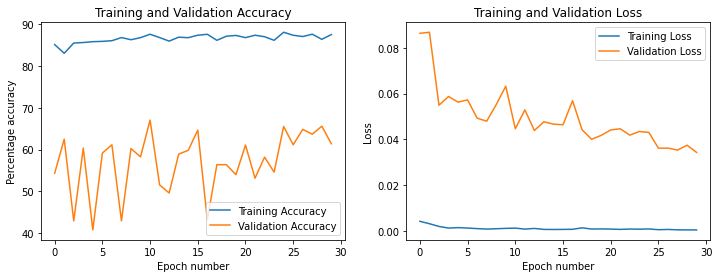

In [34]:
acc = np.array(history.history['accuracy'])
val_acc = np.array(history.history['val_accuracy'])

loss = np.array(history.history['loss'])
val_loss = np.array(history.history['val_loss'])

epochs_range = range(epochs)

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc * 100, label='Training Accuracy')
plt.plot(epochs_range, val_acc * 100, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.xlabel("Epoch number")
plt.ylabel("Percentage accuracy")
plt.title("Training and Validation Accuracy")

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.xlabel("Epoch number")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.show()

# Predicting an image.

The following function takes the name of an image and its corresponding prediction by the model. The difference between the true and predicted rotation is then calculated as Euler angles.

The rotations are applied to the nanoparticles using 3x3 rotation matrices. The Gram–Schmidt process can then be used to represent this 3x3 matrix in 6D. The function converts this 6D representation back into a matrix from which the Euler angles can be calculated.

In [35]:
def predict_image(prediction, img_name):
  name = img_name.split()
  actual_rx = name[2][2:]
  actual_ry = name[3][2:]
  actual_rz = name[4][2:]

  actual_euler = np.asarray([int(actual_rx), int(actual_ry), int(actual_rz)])

  rotation = np.asarray(prediction).reshape((2, 3)).T
  v1 = rotation[:, 0]
  v2 = rotation[:, 1]

  e1 = v1 / np.linalg.norm(v1)

  u2 = v2 - ((e1 * v2) * e1)
  e2 = u2 / np.linalg.norm(u2)

  e3 = np.cross(e1, e2) 

  rotation = np.vstack((e1, e2, e3)).T
  rotation_euler = R.from_matrix(rotation).as_euler("xyz", degrees=True)

  # print("Actual: \t%s \t| Predicted: \t%s \t| Difference: \t%s" % (actual_euler, np.round(rotation_euler, 1), np.round(rotation_euler-actual_euler, 1)))

  return (np.abs(rotation_euler - actual_euler), actual_euler.tolist())

In [36]:
predictions = model.predict(test_dataset)

In [37]:
dr = [] # Difference between predicted and true rotations
tr = [] # List of all the different true rotations

for index in range(len(predictions)):
  results = predict_image(predictions[index], test_names[index])
  dr.append(results[0])
  if results[1] not in tr:
    tr.append(results[1])

dr = np.array(dr)

num_rots = len(tr)
imgs_per_rot = int(test_imgs.shape[0] / num_rots)

tr = np.array(tr)
dr = dr.reshape((num_rots, imgs_per_rot, 3))
x_count = np.shape(np.unique(tr[:,0]))[0]
y_count = np.shape(np.unique(tr[:,1]))[0]
rx_min, rx_max = np.min(tr[:,0]), np.max(tr[:,0])
ry_min, ry_max = np.min(tr[:,1]), np.max(tr[:,1])

The following function sorts the data to make it easy to compare how the average difference in rotation around the x and y axes compare to the true rotation of the nanoparticle.

In [38]:
def sort_predictions(dr, tr, const="y"):
  if const == "y":
    indices = [1, 0]
    count_order = [y_count, x_count]
  else:
    indices = [0, 1]
    count_order = [x_count, y_count]

  sorted_dr = dr[np.argsort(tr.T[indices[0]])]
  sorted_tr = tr[np.argsort(tr.T[indices[0]])]

  sorted_tr = np.reshape(sorted_tr, (count_order[0], count_order[1], 3))
  sorted_dr = np.reshape(sorted_dr, (count_order[0], count_order[1], imgs_per_rot, 3))

  for index in range(np.shape(sorted_tr)[0]):
    sort_order = np.argsort(sorted_tr[index][:,indices[1]])
    sorted_tr[index] = sorted_tr[index][sort_order]
    sorted_dr[index] = sorted_dr[index][sort_order]
  
  return sorted_dr, sorted_tr

In [39]:
dr_sortx, tr_sortx = sort_predictions(dr, tr, const="y")
dr_sorty, tr_sorty = sort_predictions(dr, tr, const="x")

Visualising how accurately the model predicts rotations. The following graphs show the model's predictions for each orientation.

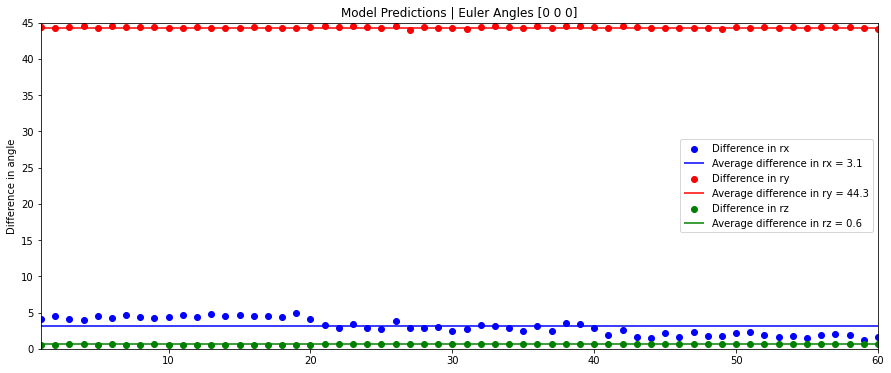

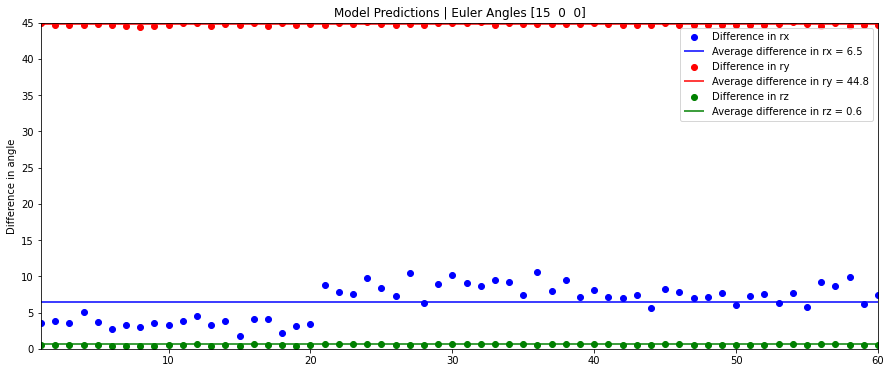

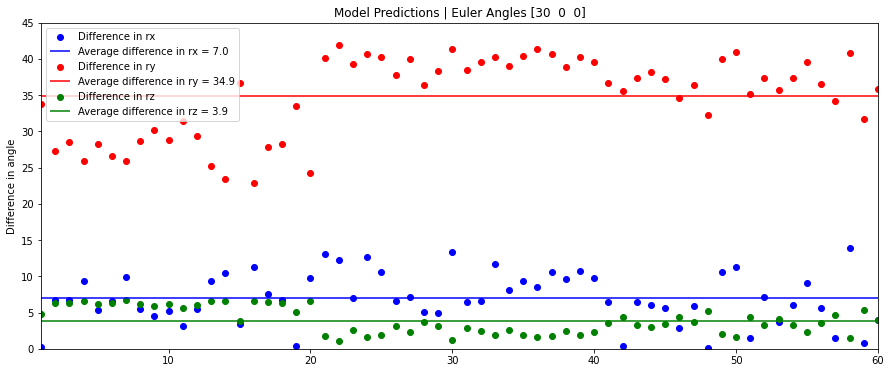

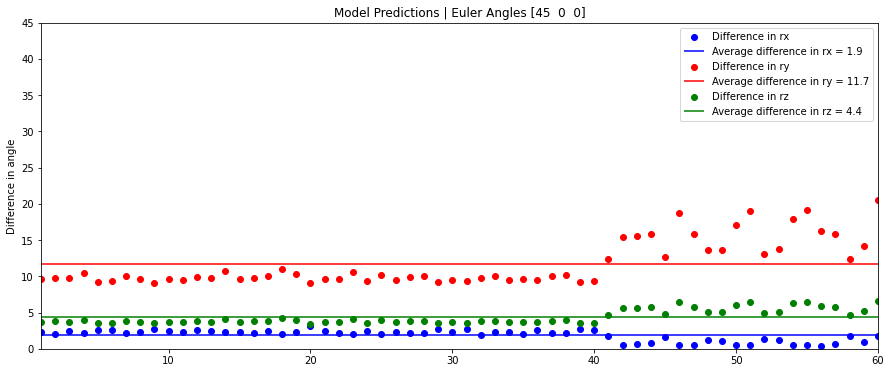

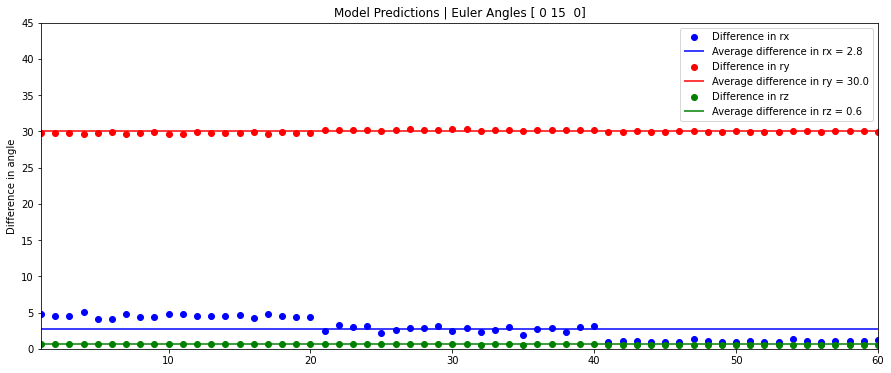

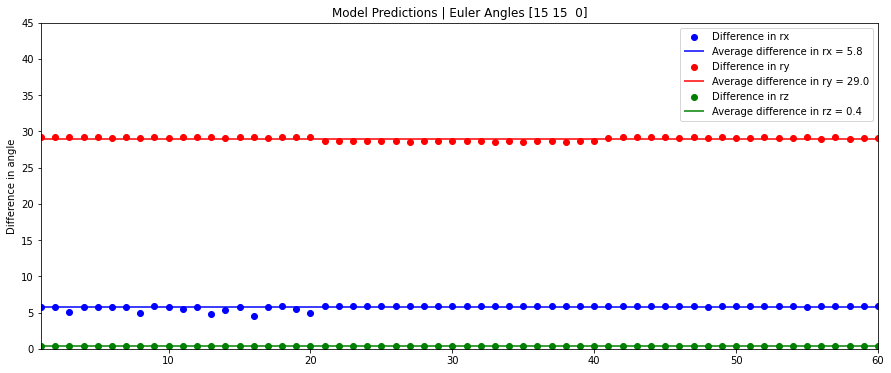

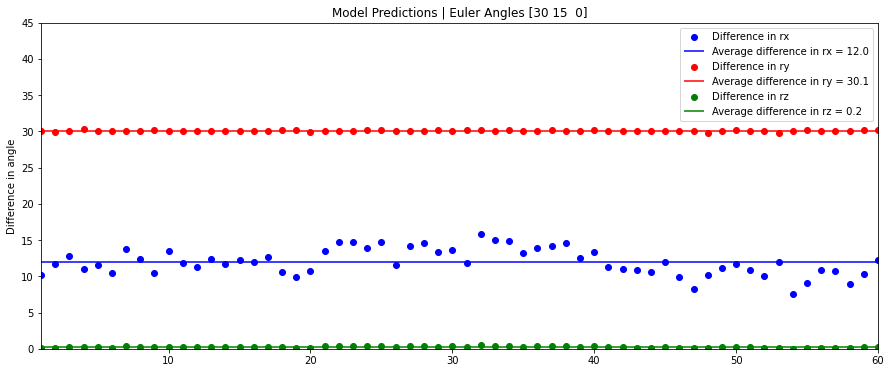

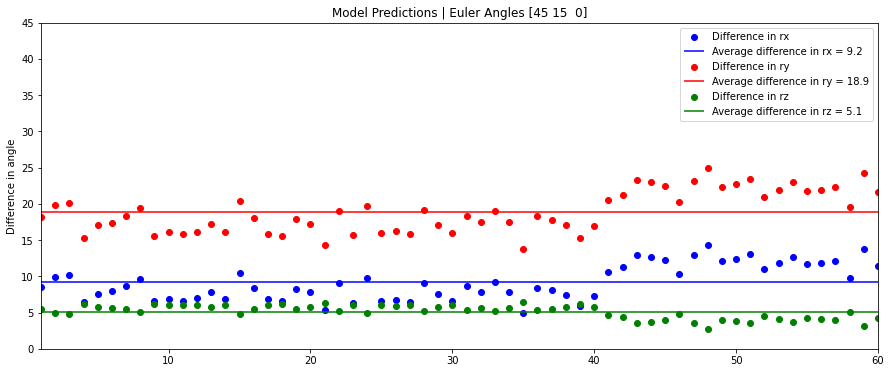

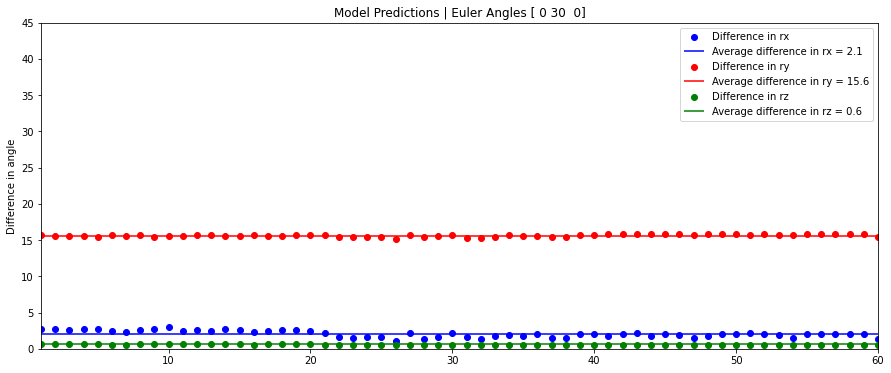

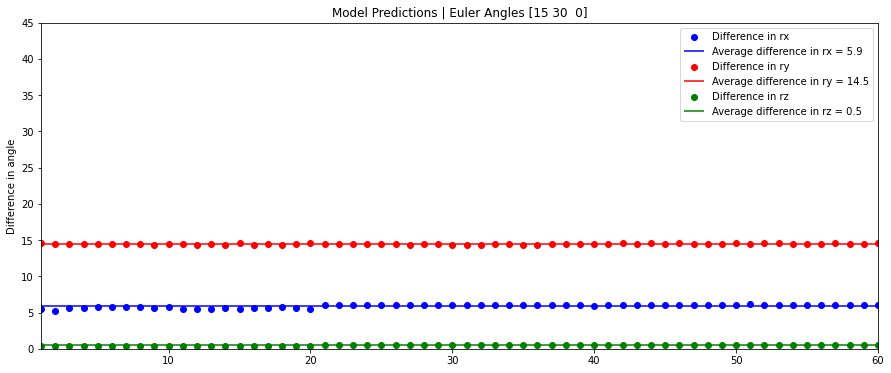

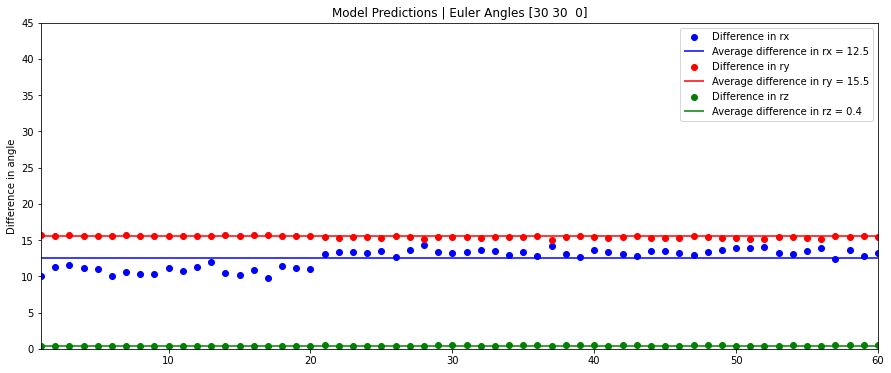

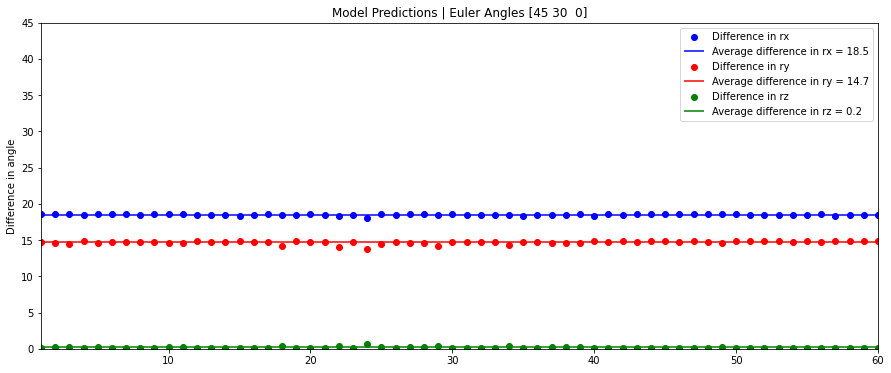

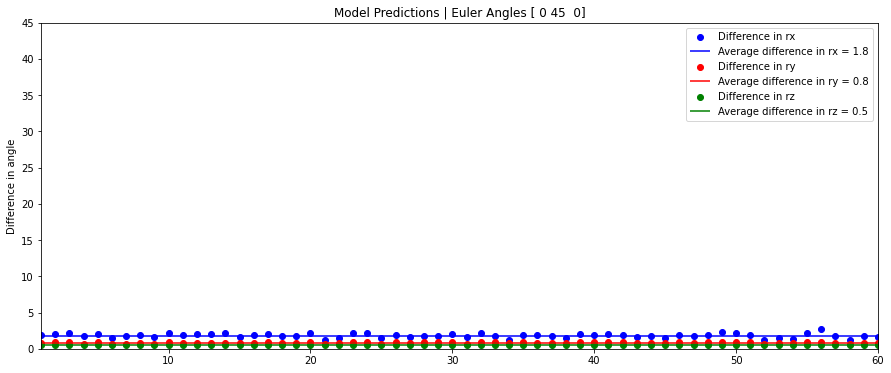

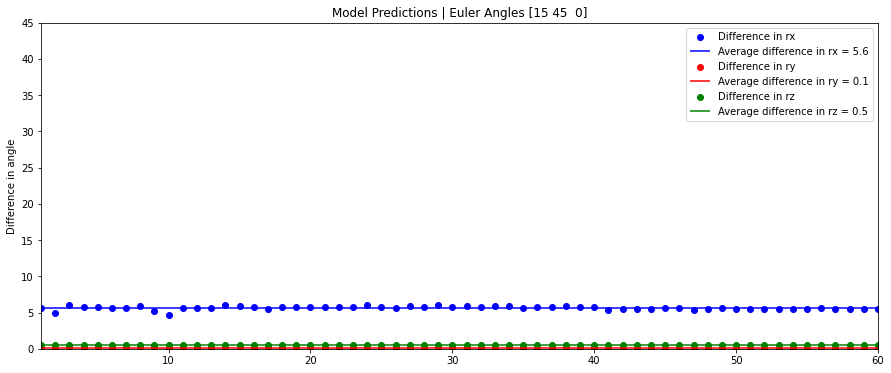

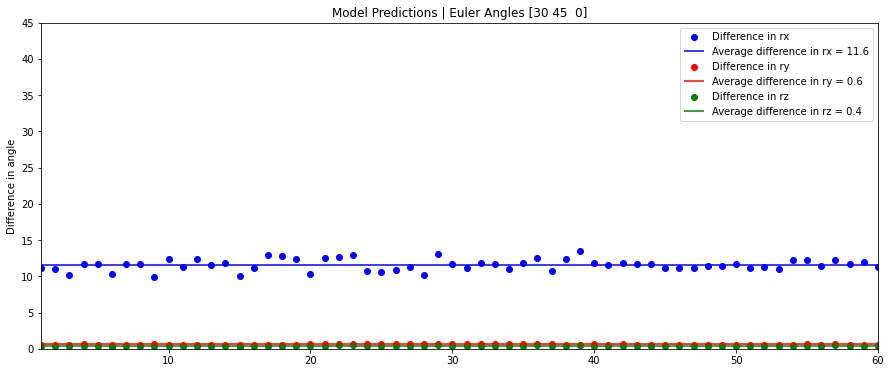

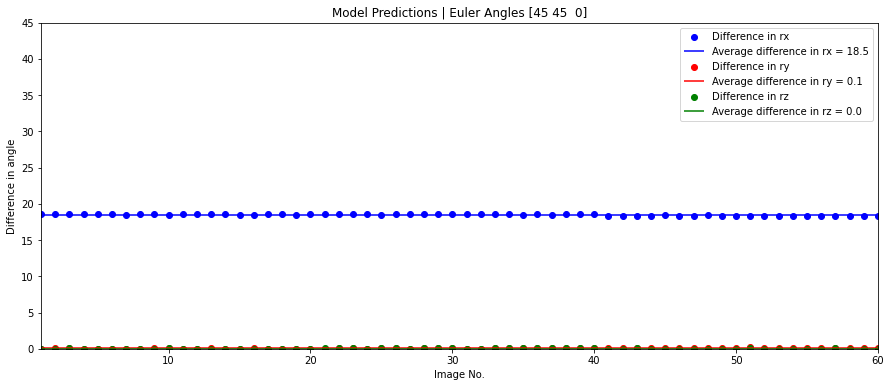

In [40]:
drx_mean = []

for index_y in range(dr_sortx.shape[0]):
  for index_x in range(dr_sortx[index_y].shape[0]):
    rot_set = dr_sortx[index_y][index_x]
    
    rx = rot_set[:,0]
    rx_mean = np.round(np.mean(rx), 1)
    drx_mean.append(rx_mean)
    ry = rot_set[:,1]
    ry_mean = np.round(np.mean(ry), 1)
    rz = rot_set[:,2]
    rz_mean = np.round(np.mean(rz), 1)

    x = np.arange(rot_set.shape[0]) + 1

    plt.figure(figsize=(15, 6))
    plt.subplot(111)
    plt.scatter(x, rx, c='b', label='Difference in rx')
    plt.hlines(rx_mean, x[0], x[-1], 'b', label='Average difference in rx = %s' % rx_mean)
    plt.scatter(x, ry, c='r', label='Difference in ry')
    plt.hlines(ry_mean, x[0], x[-1], 'r', label='Average difference in ry = %s' % ry_mean)
    plt.scatter(x, rz, c='g', label='Difference in rz')
    plt.hlines(rz_mean, x[0], x[-1], 'g', label='Average difference in rz = %s' % rz_mean)
    plt.ylabel("Difference in angle")
    plt.xlim([x[0], x[-1]])
    plt.ylim([0, np.max([rx_max - rx_min, ry_max - ry_min])])
    plt.legend(loc='best')
    plt.title("Model Predictions | Euler Angles %s" % tr_sortx[index_y][index_x])

plt.xlabel("Image No.")
plt.show()

In [41]:
dry_mean = []

for index_x in range(dr_sorty.shape[0]):
  for index_y in range(dr_sorty[index_x].shape[0]):
    rot_set = dr_sorty[index_x][index_y]
    
    rx = rot_set[:,0]
    rx_mean = np.round(np.mean(rx), 1)
    ry = rot_set[:,1]
    ry_mean = np.round(np.mean(ry), 1)
    dry_mean.append(ry_mean)
    rz = rot_set[:,2]
    rz_mean = np.round(np.mean(rz), 1)

drx_mean = np.array(drx_mean).reshape((y_count, x_count))
dry_mean = np.array(dry_mean).reshape((x_count, y_count))

The average difference for each orientation is plotted to visualise how the accuracy of the model varies with rotation around the x and y axes.

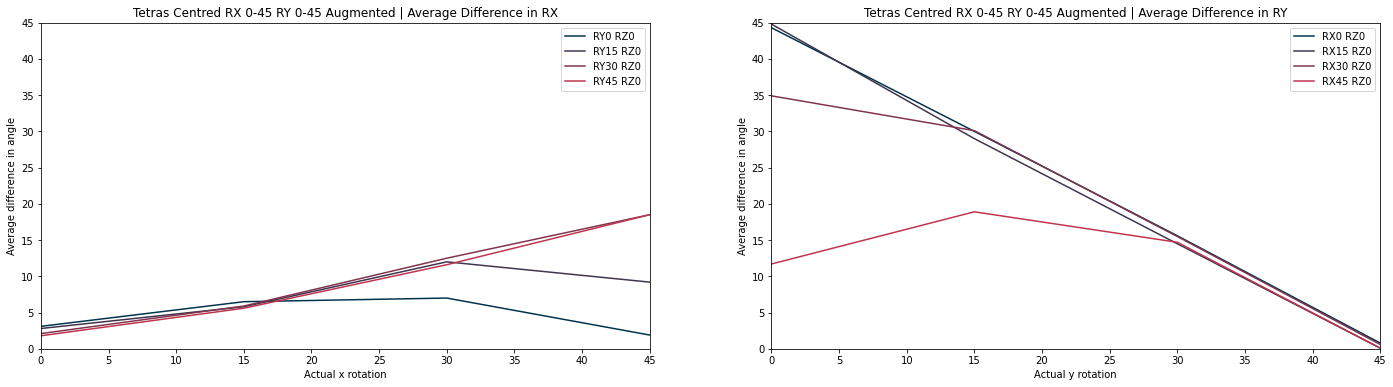

In [42]:
plt.figure(figsize=(24, 6))
plt.subplot(121)

for index in range(drx_mean.shape[0]):
  plt.plot(tr_sortx[index][:,0], drx_mean[index], c=(index / x_count, 0.2, 0.3), label="RY%s RZ%s" % (tr_sortx[index][0][1], tr_sortx[index][0][2]))

plt.xlabel("Actual x rotation")
plt.ylabel("Average difference in angle")
plt.xlim([rx_min, rx_max])
plt.ylim([0, np.max([rx_max - rx_min, ry_max - ry_min])])
plt.title("%s | Average Difference in RX" % folder_name)
plt.legend()

plt.subplot(122)

for index in range(dry_mean.shape[0]):
  plt.plot(tr_sorty[index][:,1], dry_mean[index], c=(index / y_count, 0.2, 0.3), label="RX%s RZ%s" % (tr_sorty[index][0][0], tr_sorty[index][0][2]))

plt.xlabel("Actual y rotation")
plt.ylabel("Average difference in angle")
plt.xlim([ry_min, ry_max])
plt.ylim([0, np.max([rx_max - rx_min, ry_max - ry_min])])
plt.title("%s | Average Difference in RY" % folder_name)
plt.legend()

plt.show()